In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import warnings

pd.set_option('display.max_columns', None)

import sys 
sys.path.append(r'..\utils') 
from utils import get_seaad_colors, get_tx_order

c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Params

In [2]:
compartment_type = 'dendrite' #dendrite, axon, both 
feature_type = 'removeSomaDepth' #all, removeSomaDepth, removeAllDepth



Choose seaad mapping alg

In [3]:
#HANN mapping
class_col = 'class_label_Hierarchical'
subclass_col = 'subclass_label_Hierarchical'
cluster_col = 'cluster_label_Hierarchical'

### Data wrangling

In [4]:

#Load cell data
data_root = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\Features\{}'.format(compartment_type)
out_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\analysis\20251010_seaad\M_UMAP\{}'.format(compartment_type)
os.makedirs(out_dir, exist_ok=True)

metadata = pd.read_csv(os.path.join(data_root, 'metadata.csv'))
metadata = metadata.rename(columns={'cell_id' : 'specimen_id'})

features = pd.read_csv(os.path.join(data_root, 'RawFeatureWide.csv'))
features = features.rename(columns={'soma_aligned_dist_from_pia_x' : 'soma_aligned_dist_from_pia'})

color_dict = get_seaad_colors()


In [5]:
#identify ttype and feature columns
feature_columns = features.columns[1:]
ttype_columns = [class_col, cluster_col, subclass_col]

In [6]:
# Filter out 'soma_aligned_dist_from_pia'
if feature_type == 'removeSomaDepth' or feature_type == 'removeAllDepth': 
    feature_columns = [col for col in feature_columns if col != 'soma_aligned_dist_from_pia']
    print('removed soma distance')
if feature_type == 'removeAllDepth':
    feature_columns = [col for col in feature_columns if not 'depth' in col]
    print('removed depth PCs')


removed soma distance


In [7]:
#when cells don't have apicals, they return nan for some apical features. Fill those with zeros. 
apical_features = [f for f in features.columns[1:].tolist() if 'apical' in f]
basal_features = [f for f in features.columns[1:].tolist() if not 'apical' in f]
apical_features.insert(0, 'specimen_id')
basal_features.insert(0, 'specimen_id')

apical_features_filled = features[apical_features].fillna(0)
features_filled = apical_features_filled.merge(features[basal_features], how='inner', on='specimen_id')

features_filled = features_filled[~features_filled.isnull().any(axis=1)] #select rows without any nan values 

In [8]:
#merge cell data
cells = metadata.merge(features_filled, how='inner', on='specimen_id')


In [9]:
cells[subclass_col].unique()

array(['L2/3 IT', 'L4 IT', 'L6 IT Car3', 'L6 IT', 'L5/6 NP', 'L6 CT',
       'L5 IT', 'L5 ET', 'L6b', 'L5 ET_ME'], dtype=object)

In [10]:
#add layer groups 
layer_subclass_groups = {
 'L2/3 IT' : 'L2/3', 
 'L4 IT' : 'L4', 
 'L5 ET' : 'L5', 
 'L5 ET_ME' : 'L5',
 'L5 IT' : 'L5', 
 'L5/6 NP' : 'L5', 
 'L6 CT' : 'L6', 
 'L6b' : 'L6', 
 'L6 IT' : 'L6', 
 'L6 IT Car3' : 'L6'
}
cells['layer_group'] = cells[subclass_col].map(lambda x: layer_subclass_groups[x])

In [11]:
# Get custom transcriptomic order
ttype_order, subclass_order = get_tx_order()
group_order = {
    'subclass_label' : subclass_order,
    't_type' :  ttype_order
}

In [12]:
# def get_tx_order_dict(subclass_order_file, ttype_order_file):

#     with open(subclass_order_file, 'r') as file: subclass_order = [line.strip() for line in file]
#     with open(ttype_order_file, 'r') as file: ttype_order = [line.strip() for line in file]

#     tx_order_dict = {}
#     for subclass in subclass_order:
#         tx_order_dict[subclass] = [t for t in ttype_order if t.startswith(subclass)]

#     return tx_order_dict

In [13]:
# #get transcriptomic order (from RD - mostly trying to keep ttypes ordered by depth within subclasses)
# subclass_order_file = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\formatting_dicts\subclass_order.txt'
# ttype_order_file = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\formatting_dicts\ttype_order.txt'
# tx_order_dict = get_tx_order_dict(subclass_order_file=subclass_order_file, ttype_order_file=ttype_order_file)

# with open(subclass_order_file, 'r') as file:
#     subclass_order = [line.strip() for line in file]
# with open(ttype_order_file, 'r') as file:
#     ttype_order = [line.strip() for line in file]

# group_order = {
#     'subclass_label' : subclass_order,
#     't_type' : ttype_order
# }

In [14]:
[c for c in feature_columns if 'dist' in c.lower() or 'depth' in c.lower()]

['apical_dendrite_depth_pc_0',
 'apical_dendrite_depth_pc_1',
 'apical_dendrite_depth_pc_2',
 'apical_dendrite_depth_pc_3',
 'apical_dendrite_depth_pc_4',
 'apical_dendrite_max_euclidean_distance',
 'apical_dendrite_max_path_distance',
 'apical_dendrite_mean_moments_along_max_distance_projection',
 'apical_dendrite_std_moments_along_max_distance_projection',
 'axon_exit_distance',
 'basal_dendrite_max_euclidean_distance',
 'basal_dendrite_max_path_distance']

### PCA

In [15]:
cells_input = cells[feature_columns] #input for pca - just morpho features 

#scale data for PCA 
scaler = StandardScaler()
scaler.fit(cells_input)
scaled_data = scaler.transform(cells_input)

In [16]:
#PCA with num components that explain 95% variance. 

pca95 = PCA(n_components=0.95, svd_solver='full')
x_pca95 = pca95.fit_transform(scaled_data)

#make pca df for visuals
x_pca95_df = pd.concat([cells[['specimen_id', class_col, subclass_col, cluster_col]], pd.DataFrame(x_pca95)], axis=1)

x_pca95.shape


(319, 25)

Text(0, 0.5, 'PCA 2')

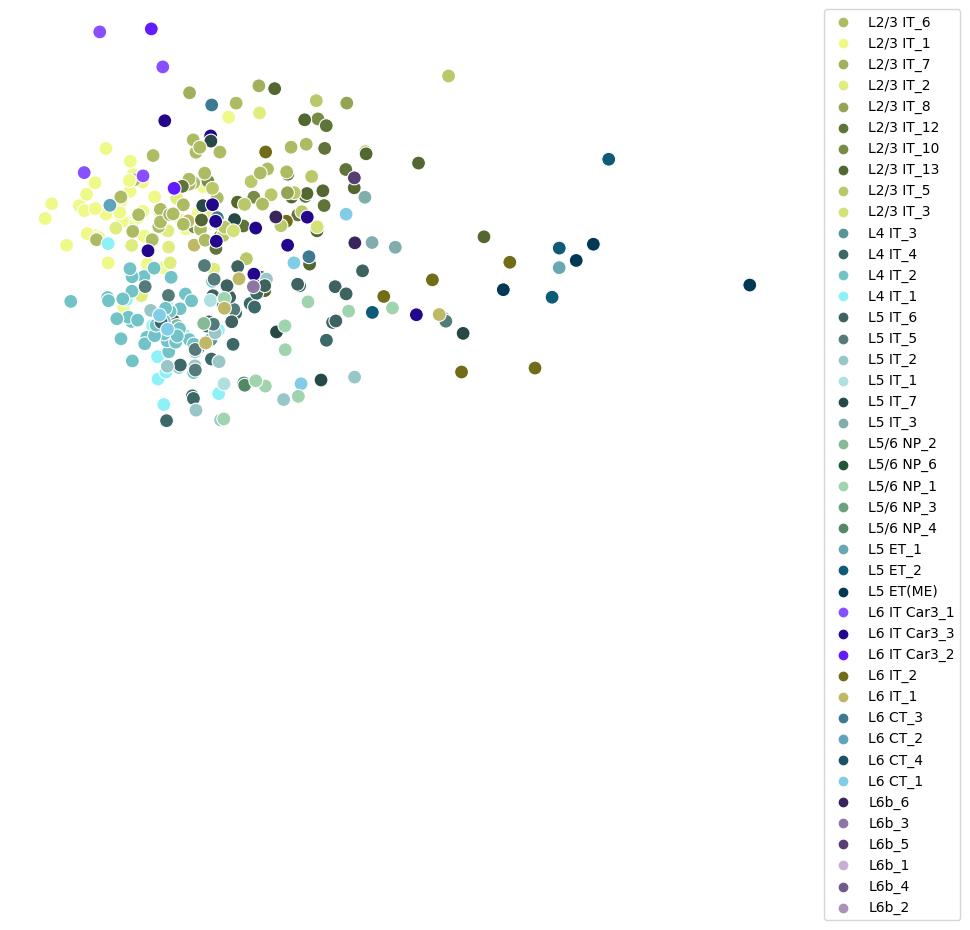

In [17]:
#show PCA 1 and 2 colored by ttype 
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
ax.axis('off')

sns.scatterplot(data=x_pca95_df, x=0, y=1, hue=cluster_col, hue_order = group_order['t_type'], palette=color_dict, s=100)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')



In [18]:
#save PCA data
x_pca95_df = pd.DataFrame(x_pca95)
x_pca95_df.to_csv(os.path.join(out_dir, 'human_excitatory_pca_95_{}_{}_features.csv'.format(feature_type, compartment_type)), index=False)


### UMAP from PCA

Parameter fitting

In [19]:
# #UMAP - testing num neighbors 
# nns = [13, 15, 17, 20, 22, 25] #num neighbors 
# md = 0.1 #min dist 

# fig_path = os.path.join(out_dir, 'human_excitatory_pca95_umap_{}_{}_features_nNeighborsTesting_minDist{}.pdf'.format(feature_type, compartment_type, str(md).replace('.', '-')))

# with PdfPages(fig_path) as pdf:
#   with warnings.catch_warnings():
#     warnings.simplefilter(action='ignore', category=FutureWarning)

#   for nn in nns:
#     #2d umap from pca
#     umap_2d = UMAP(n_components=2, n_neighbors=nn, min_dist=md, metric='euclidean', init='random', random_state=0)
#     proj_2d = umap_2d.fit_transform(x_pca95_df)
#     proj_2d_df = pd.concat([cells[['specimen_id', class_col, subclass_col, cluster_col]], pd.DataFrame(proj_2d)], axis=1)

#     fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(6,6)) #,sharey=True, figsize=(20,10)) 

#     #plot
#     # plt.scatter(proj_2d[:,0], proj_2d[:,1], c=seaad_color_dict)
#     sns.scatterplot(data=proj_2d_df, x=0, y=1, hue=cluster_col, hue_order=group_order['t_type'], palette=seaad_color_dict, s=100)
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#     plt.xlabel('UMAP 1')
#     plt.ylabel('UMAP 2')
#     plt.title('n_neighbors {}, min_dist {}'.format(nn, md))

#     #save fig
#     pdf.savefig(fig, bbox_inches='tight')
#     plt.show() #show the fig
#     plt.clf() #destoy current fig to save memory


In [20]:
# #UMAP - testing min distance
# nn = 15 #num neighbors 
# mds = [0.0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.8, 0.99] #min dist 

# fig_path = os.path.join(out_dir, 'human_excitatory_pca95_umap_{}_{}_features_nNeighbors{}_minDistTesting.pdf'.format(feature_type, compartment_type, str(nn).replace('.', '-')))

# with PdfPages(fig_path) as pdf:
#   with warnings.catch_warnings():
#     warnings.simplefilter(action='ignore', category=FutureWarning)

#   for md in mds:
#     #2d umap from pca
#     umap_2d = UMAP(n_components=2, n_neighbors=nn, min_dist=md, metric='euclidean', init='random', random_state=0)
#     proj_2d = umap_2d.fit_transform(x_pca95_df)
#     proj_2d_df = pd.concat([cells[['specimen_id', class_col, subclass_col, cluster_col]], pd.DataFrame(proj_2d)], axis=1)

#     fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(6,6)) #,sharey=True, figsize=(20,10)) 

#     #plot
#     # plt.scatter(proj_2d[:,0], proj_2d[:,1], c=seaad_color_dict)
#     sns.scatterplot(data=proj_2d_df, x=0, y=1, hue=cluster_col, hue_order=group_order['t_type'], palette=seaad_color_dict, s=100)
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#     plt.xlabel('UMAP 1')
#     plt.ylabel('UMAP 2')
#     plt.title('n_neighbors {}, min_dist {}'.format(nn, md))

#     #save fig
#     pdf.savefig(fig, bbox_inches='tight')
#     plt.show() #show the fig
#     plt.clf() #destoy current fig to save memory


UMAP with best params

In [21]:
NN = 15
MD = 0.1

In [22]:
def to_camel_case(s):
    s = s.title().replace('_', ' ').replace('-', ' ')  # Capitalize and replace underscores/dashes
    s = ''.join(s.split())  # Remove spaces
    return s[0].upper() + s[1:]  # Lowercase the first letter

c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


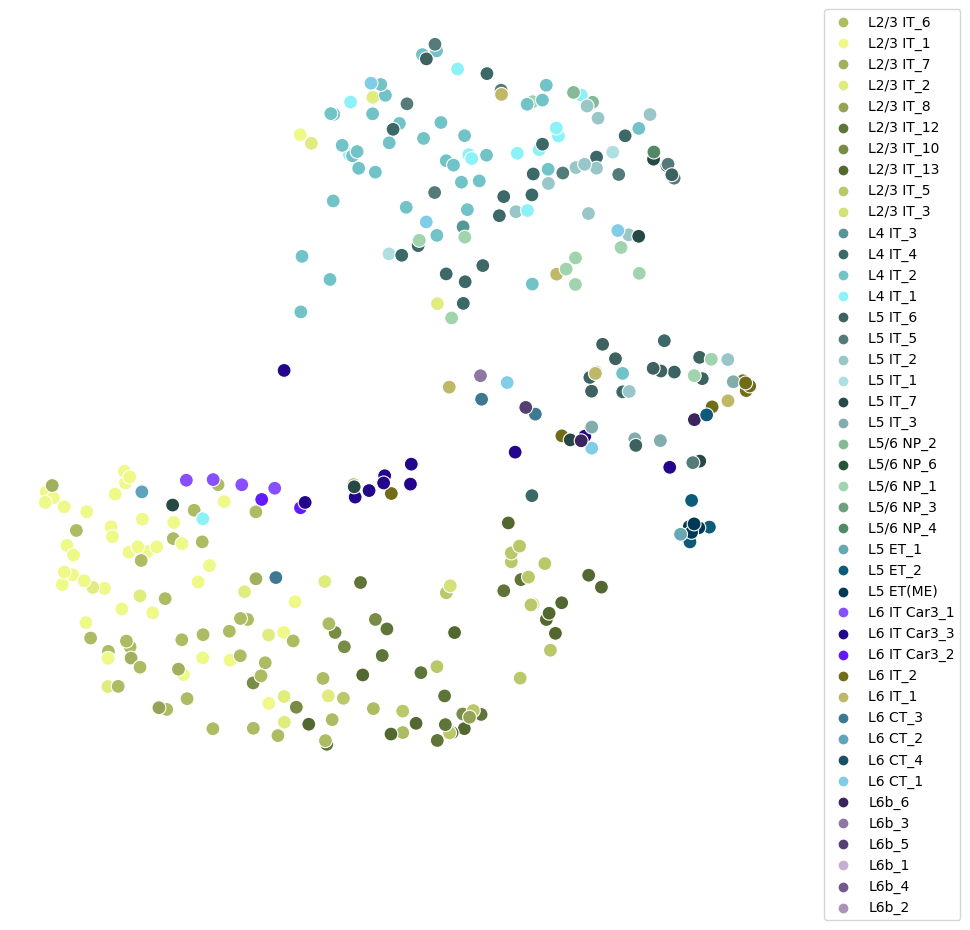

<Figure size 640x480 with 0 Axes>

In [23]:
#UMAP - best combo 
nn = NN
md = MD

fig_path = os.path.join(out_dir, 'human_excitatory_pca95_umap_{}_{}_features_nNeighbors{}_minDist{}.pdf'.format(feature_type, compartment_type, nn, str(md).replace('.', '-')))


with PdfPages(fig_path) as pdf:
  with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

  #compute umap
  umap_2d = UMAP(n_components=2, n_neighbors=nn, min_dist=md, metric='euclidean', init='random', random_state=0)
  proj_2d = umap_2d.fit_transform(x_pca95)
  proj_2d_df = pd.concat([cells[['specimen_id', class_col, subclass_col, cluster_col]], pd.DataFrame(proj_2d)], axis=1)


  fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10,10)) #,sharey=True, figsize=(20,10)) 
  ax.axis('off')

  #plot
  sns.scatterplot(data=proj_2d_df, x=0, y=1, hue=cluster_col, hue_order=group_order['t_type'], palette=color_dict, s=100)

  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
  plt.xlabel('UMAP 1')
  plt.ylabel('UMAP 2')
  # plt.title('color {}'.format(color_val))

  #save fig
  pdf.savefig(fig, bbox_inches='tight')
  plt.show() #show the fig
  plt.clf() #destoy current fig to save memory


In [24]:
# umap into df
umap_df = pd.DataFrame(proj_2d, columns=['umap_1', 'umap_2'])
umap_df['specimen_id'] = cells['specimen_id'].values.tolist()
umap_df = umap_df[['specimen_id', 'umap_1', 'umap_2']]
cells = cells.merge(umap_df, how='inner', on='specimen_id')

In [25]:
umap_df.to_csv(os.path.join(out_dir, f'human_excitatory_umap_2d_nn{NN}_md{MD}_{feature_type}.csv'), index=False)


##### Color by ttype, subclass, and features

In [25]:
#color vars and corresponding color dicts
color_by = {}
color_by[subclass_col] = color_dict
color_by[cluster_col] = color_dict
color_by['soma_aligned_dist_from_pia'] = None
# color_by['cortex_layer'] = None
for f in feature_columns: color_by[f] = None


In [26]:
#UMAP

nn = NN
md = MD

fig_path = os.path.join(out_dir, 'human_excitatory_pca95_umap_{}_{}_features_nNeighbors{}_minDist{}_variousColors.pdf'.format(feature_type, compartment_type, nn, str(md).replace('.', '-')))

with PdfPages(fig_path) as pdf:
  with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

  #compute umap
  umap_2d = UMAP(n_components=2, n_neighbors=nn, min_dist=md, metric='euclidean', init='random', random_state=0)
  proj_2d = umap_2d.fit_transform(x_pca95)

  for color_var, color_var_dict in color_by.items():

    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(5,5))

    #plot
    if 'subclass' in color_var: ax = sns.scatterplot(data=cells.sort_values(by=color_var), x='umap_1', y='umap_2', hue=color_var, hue_order=group_order['subclass_label'], palette=color_var_dict)
    elif 'cluster' in color_var: 
      order = group_order['t_type']
      ax = sns.scatterplot(data=cells.sort_values(by=color_var), x='umap_1', y='umap_2', hue=color_var, hue_order=order, palette=color_var_dict)
    else: ax = sns.scatterplot(data=cells, x='umap_1', y='umap_2', hue=color_var, palette=color_var_dict)

    #format
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    for spine in ax.spines.values(): spine.set_visible(False)
    ax.set_xlabel('M UMAP 1')
    ax.set_ylabel('M UMAP 2')
    ax.set_title(color_var)

    #save fig
    pdf.savefig(fig, bbox_inches='tight')
    # plt.show() #show the fig
    plt.clf() #destoy current fig to save memory


c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\sarah.wallingbell\AppData\Local\Temp\ipykernel_18860\3754361070.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(5,5))


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

#### Color subclass ttypes (like ephys plots)

In [27]:
subclass_ttype_dict = {}
for subclass in group_order['subclass_label']:
    subclass_ttype_dict[subclass] = list(cells[cells[subclass_col] == subclass][cluster_col].unique())

    #UMAP

    nn = NN
    md = MD

    fig_path = os.path.join(out_dir, 'human_excitatory_pca95_umap_{}_{}_features_nNeighbors{}_minDist{}_colorSubclassTtypes.pdf'.format(feature_type, compartment_type, nn, str(md).replace('.', '-')))

    with PdfPages(fig_path) as pdf:
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)

            #compute umap
            umap_2d = UMAP(n_components=2, n_neighbors=nn, min_dist=md, metric='euclidean', init='random', random_state=0)
            proj_2d = umap_2d.fit_transform(x_pca95)

            subclasses = list(subclass_ttype_dict.keys())
            for subclass in subclasses:

                #create a color dict for this subclass (non subclass ttypes are grey)
                ttypes = subclass_ttype_dict[subclass]
                color_palette = {c:color_dict[c] if c in ttypes else 'lightgrey' for c in cells[cluster_col].unique()}
                
                #plot
                fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(7,7)) #,sharey=True, figsize=(20,10)) 
                ax = sns.scatterplot(data=cells, x='umap_1', y='umap_2', hue=cluster_col, hue_order=[x for x in ttype_order if x in cells[cluster_col].unique()], palette=color_palette)

                #format
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
                ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
                for spine in ax.spines.values(): spine.set_visible(False)
                ax.set_xlabel('M UMAP 1')
                ax.set_ylabel('M UMAP 2')
                ax.set(title=subclass)

                #save fig
                pdf.savefig(fig, bbox_inches='tight')
                # plt.show() #show the fig
                plt.clf() #destoy current fig to save memory




c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

#### Color layer groups (like ephys plots) 

In [28]:
layer_subclas_dict = {}
for layer in sorted(cells['layer_group'].unique()):
    layer_subclas_dict[layer] = list(cells[cells['layer_group'] == layer][cluster_col].unique())

    #UMAP

    nn = NN
    md = MD

    fig_path = os.path.join(out_dir, 'human_excitatory_pca95_umap_{}_{}_features_nNeighbors{}_minDist{}_colorLayerTtypes.pdf'.format(feature_type, compartment_type, nn, str(md).replace('.', '-')))

    with PdfPages(fig_path) as pdf:
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)

            #compute umap
            umap_2d = UMAP(n_components=2, n_neighbors=nn, min_dist=md, metric='euclidean', init='random', random_state=0)
            proj_2d = umap_2d.fit_transform(x_pca95)

            layers = list(layer_subclas_dict.keys())
            for layer in layers:

                #create a color dict for this subclass (non subclass ttypes are grey)
                ttypes = layer_subclas_dict[layer]
                color_palette = {c:color_dict[c] if c in ttypes else 'lightgrey' for c in cells[cluster_col].unique()}
                
                #plot
                fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(7,7)) #,sharey=True, figsize=(20,10)) 
                ax = sns.scatterplot(data=cells, x='umap_1', y='umap_2', hue=cluster_col, hue_order=[x for x in ttype_order if x in cells[cluster_col].unique()], palette=color_palette)

                #format
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
                ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
                for spine in ax.spines.values(): spine.set_visible(False)
                ax.set_xlabel('M UMAP 1')
                ax.set_ylabel('M UMAP 2')
                ax.set(title=layer)

                #save fig
                pdf.savefig(fig, bbox_inches='tight')
                # plt.show() #show the fig
                plt.clf() #destoy current fig to save memory




c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs\morph_utils_v3\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\sarah.wallingbell\AppData\Local\anaconda3\envs

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>

<Figure size 700x700 with 0 Axes>